# Group Splitter Embeddings

This notebook compares:
- **Input space** (per-hit input features used by the model)
- **Model embedding space** (true latent vectors from `model.extract_embeddings(...)`)

It uses a trained exported group-splitter model and aligned group-classifier probabilities.


In [1]:
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pyarrow.parquet as pq
import torch

from pioneerml.common.loader import GroupSplitterGraphLoader
from pioneerml.common.models.classifiers import GroupSplitter
from pioneerml.common.evaluation.plots import plot_embedding_space
from pioneerml.common.zenml import utils as zenml_utils

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Project root: {PROJECT_ROOT}")
print(f"Device: {device}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace
Device: cuda


## Inputs

In [2]:
data_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Optional quick subset
# parquet_paths = parquet_paths[:1]

parquet_paths = [p.resolve() for p in parquet_paths]
if not parquet_paths:
    raise RuntimeError(f"No parquet files found in {data_dir}")

pred_dir = Path(PROJECT_ROOT) / "data" / "group_classifier"


def _pick_pred_path(main_path: Path) -> Path | None:
    stem = main_path.stem
    candidates = [
        pred_dir / f"{stem}_preds.parquet",
        pred_dir / f"{stem}_preds_latest.parquet",
        pred_dir / "group_classifier_preds_latest.parquet",
    ]
    for cand in candidates:
        if cand.exists():
            return cand.resolve()
    return None


pred_paths = [_pick_pred_path(p) for p in parquet_paths]
if all(p is not None for p in pred_paths):
    group_probs_parquet_paths = [str(p) for p in pred_paths]  # type: ignore[arg-type]
else:
    # Fallback: if pred columns are already in main parquet files
    required_pred_cols = {"pred_pion", "pred_muon", "pred_mip"}
    schemas_ok = all(required_pred_cols.issubset(set(pq.read_schema(str(p)).names)) for p in parquet_paths)
    if schemas_ok:
        group_probs_parquet_paths = None
    else:
        raise RuntimeError(
            "Could not resolve group-classifier prediction files. "
            "Expected either data/group_classifier/<input_stem>_preds.parquet for each input "
            "or pred_pion/pred_muon/pred_mip columns in main parquet files."
        )

# Latest model artifacts
model_dir = Path(PROJECT_ROOT) / "trained_models" / "groupsplitter"
meta_candidates = sorted(model_dir.glob("*_meta.json"), key=lambda p: p.stat().st_mtime, reverse=True)
if not meta_candidates:
    raise RuntimeError(f"No metadata files found in {model_dir}")

meta_path = meta_candidates[0]
meta = json.loads(meta_path.read_text())
torchscript_path = Path(meta.get("torchscript_path") or str(meta_path).replace("_meta.json", "_torchscript.pt"))
if not torchscript_path.exists():
    raise FileNotFoundError(f"TorchScript file not found: {torchscript_path}")

print(f"Using metadata:    {meta_path}")
print(f"Using torchscript: {torchscript_path}")
print(f"Num parquet files: {len(parquet_paths)}")
print(f"Using external group_probs files: {group_probs_parquet_paths is not None}")


Using metadata:    /workspace/trained_models/groupsplitter/groupsplitter_20260218_231744_meta.json
Using torchscript: /workspace/trained_models/groupsplitter/groupsplitter_20260218_231744_torchscript.pt
Num parquet files: 5
Using external group_probs files: True


## Rebuild Eager Model

In [3]:
def _strip_prefix(state_dict: dict[str, torch.Tensor], prefix: str = "model.") -> dict[str, torch.Tensor]:
    out: dict[str, torch.Tensor] = {}
    for key, value in state_dict.items():
        out[key[len(prefix):] if key.startswith(prefix) else key] = value
    return out

hpo_params = dict(meta.get("hpo_params") or {})
model_cfg = dict(hpo_params.get("model") or {})
data_shapes = dict(meta.get("data_shapes") or {})

cfg = {
    "in_channels": int(model_cfg.get("in_channels", data_shapes.get("x_dim", 4))),
    "prob_dimension": int(model_cfg.get("prob_dimension", data_shapes.get("num_classes", 3))),
    "hidden": int(model_cfg.get("hidden", 128)),
    "heads": int(model_cfg.get("heads", 4)),
    "layers": int(model_cfg.get("layers", 3)),
    "dropout": float(model_cfg.get("dropout", 0.1)),
    "num_classes": int(data_shapes.get("num_classes", 3)),
}

model = GroupSplitter(**cfg)
scripted = torch.jit.load(str(torchscript_path), map_location="cpu")
state = _strip_prefix(scripted.state_dict(), prefix="model.")
missing, unexpected = model.load_state_dict(state, strict=False)

print("Model config:", cfg)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model = model.to(device)
model.eval()


Model config: {'in_channels': 4, 'prob_dimension': 3, 'hidden': 234, 'heads': 6, 'layers': 2, 'dropout': 0.16804180946449349, 'num_classes': 3}
Missing keys: []
Unexpected keys: []


GroupSplitter(
  (input_proj): Linear(in_features=7, out_features=234, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x FullGraphTransformerBlock(
      (ln1): LayerNorm((234,), eps=1e-05, elementwise_affine=True)
      (attn): TransformerConv(234, 39, heads=6)
      (ln2): LayerNorm((234,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=234, out_features=936, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.16804180946449349, inplace=False)
        (3): Linear(in_features=936, out_features=234, bias=True)
      )
    )
  )
  (node_head): Linear(in_features=235, out_features=3, bias=True)
)

## Collect Input Features And Embeddings

Each sample is one hit (node):
- input feature vector = `[x, z, edep, strip_type, group_total_energy, pred_pion, pred_muon, pred_mip]`
- embedding vector = `model.extract_embeddings(batch)[node_id]`


In [4]:
max_samples = 12000
batch_size = 64

loader = GroupSplitterGraphLoader(
    parquet_paths=[str(p) for p in parquet_paths],
    group_probs_parquet_paths=group_probs_parquet_paths,
    mode="train",
    batch_size=batch_size,
    row_groups_per_chunk=4,
    num_workers=0,
)

input_feats_list: list[torch.Tensor] = []
input_targets_list: list[torch.Tensor] = []
embedding_list: list[torch.Tensor] = []
embedding_targets: list[torch.Tensor] = []
num_collected = 0

with torch.no_grad():
    for batch in loader.make_dataloader(shuffle_batches=False):
        # Input-space node features (CPU)
        x_cpu = batch.x.cpu()
        y_cpu = batch.y.cpu()
        b_cpu = batch.batch.cpu()
        probs_cpu = batch.group_probs.cpu()
        energy_cpu = batch.group_total_energy.cpu()
        node_input = torch.cat([x_cpu, energy_cpu[b_cpu], probs_cpu[b_cpu]], dim=1)

        input_feats_list.append(node_input)
        input_targets_list.append(y_cpu)

        # True model embeddings
        batch = batch.to(device)
        emb = model.extract_embeddings(batch).detach().cpu()
        embedding_list.append(emb)
        embedding_targets.append(batch.y.detach().cpu())

        num_collected += emb.size(0)
        if num_collected >= max_samples:
            break

if not embedding_list:
    raise RuntimeError("No embeddings collected. Check inputs and loader configuration.")

input_feats = torch.cat(input_feats_list, dim=0)[:max_samples]
input_targets = torch.cat(input_targets_list, dim=0)[:max_samples]
embeddings = torch.cat(embedding_list, dim=0)[:max_samples]
targets = torch.cat(embedding_targets, dim=0)[:max_samples]

print(f"Input features shape: {tuple(input_feats.shape)}")
print(f"Embeddings shape:     {tuple(embeddings.shape)}")
print(f"Targets shape:        {tuple(targets.shape)}")


Input features shape: (12000, 8)
Embeddings shape:     (12000, 235)
Targets shape:        (12000, 3)


## Plot Input Space

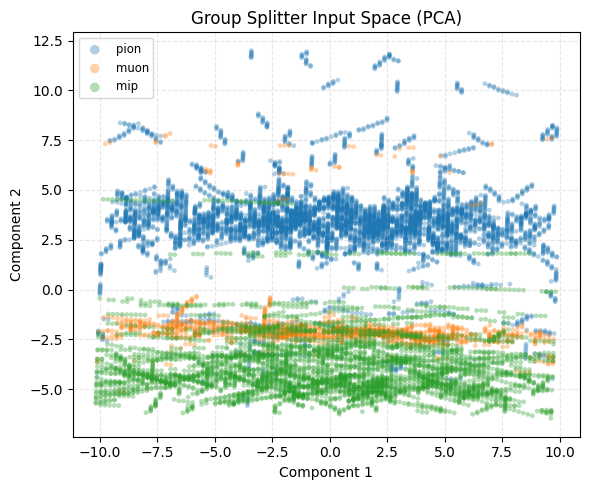

[embedding] Pre-reduced to 8 dims via PCA.


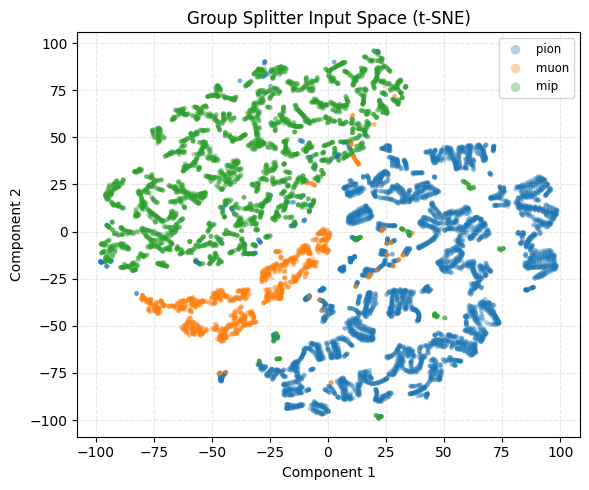

'/workspace/artifacts/validation_plots/group_splitter_embeddings/group_splitter_embeddings_20260218_234617_input_space_tsne.png'

In [5]:
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_splitter_embeddings"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_splitter_embeddings_{timestamp_str}"
class_names = ["pion", "muon", "mip"]

plot_embedding_space(
    embeddings=input_feats,
    targets=input_targets,
    class_names=class_names,
    method="pca",
    title="Group Splitter Input Space (PCA)",
    random_state=42,
    max_samples=max_samples,
    save_path=plots_dir / f"{plot_prefix}_input_space_pca.png",
    show=True,
    verbose=True,
)

plot_embedding_space(
    embeddings=input_feats,
    targets=input_targets,
    class_names=class_names,
    method="tsne",
    title="Group Splitter Input Space (t-SNE)",
    random_state=42,
    max_samples=max_samples,
    pre_pca_components=8,
    save_path=plots_dir / f"{plot_prefix}_input_space_tsne.png",
    show=True,
    verbose=True,
)


## Plot Embedding Space

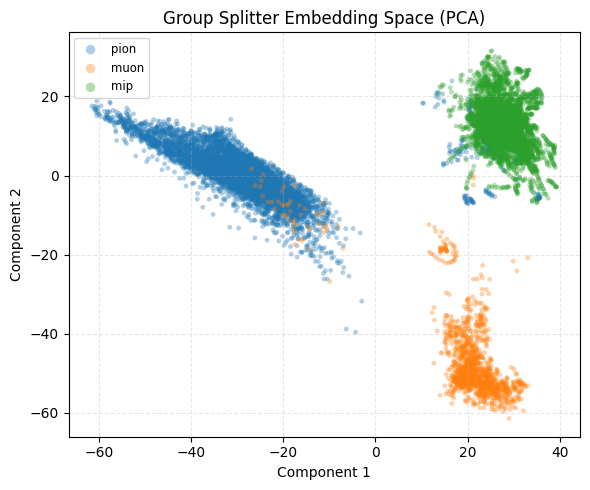

[embedding] Pre-reduced to 50 dims via PCA.


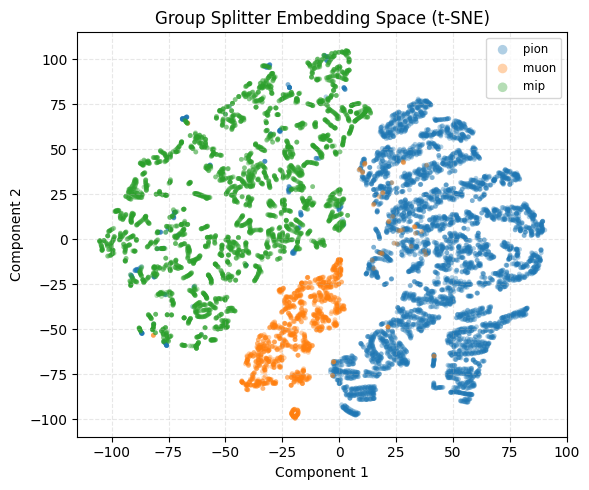

Saved plots to: /workspace/artifacts/validation_plots/group_splitter_embeddings


In [6]:
plot_embedding_space(
    embeddings=embeddings,
    targets=targets,
    class_names=class_names,
    method="pca",
    title="Group Splitter Embedding Space (PCA)",
    random_state=42,
    max_samples=max_samples,
    save_path=plots_dir / f"{plot_prefix}_embedding_space_pca.png",
    show=True,
    verbose=True,
)

plot_embedding_space(
    embeddings=embeddings,
    targets=targets,
    class_names=class_names,
    method="tsne",
    title="Group Splitter Embedding Space (t-SNE)",
    random_state=42,
    max_samples=max_samples,
    pre_pca_components=50,
    save_path=plots_dir / f"{plot_prefix}_embedding_space_tsne.png",
    show=True,
    verbose=True,
)

print(f"Saved plots to: {plots_dir}")


## Interpretation

- If embedding-space clusters separate better than input-space clusters, the model learned useful hit-level structure.
- Persistent overlap in both spaces usually indicates intrinsically ambiguous hits.
